# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import os
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('github'))))
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('../input/train_macro.csv', index_col=0, parse_dates=['timestamp'])
df_test_macro = pd.read_csv('../input/test_macro.csv', index_col=0, parse_dates=['timestamp'])

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [2]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns.drop('_timestamp')) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     569.1
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:12:37   Log-Likelihood:                -19036.
No. Observations:               30404   AIC:                         3.815e+04
Df Residuals:                   30363   BIC:                         3.849e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -0.0004   3.75e-05    -11.905      0.000      -0.001      -0.000
C(_railroad_terminal_raion)[T.yes]                         0.0036      0.018      0.201      0.841      -0.031       0.038
C(_incineration_raion)[T.yes]                             -0.0383      0.017     -2.233      0.026      -0.072      -0.005
C(_product_type)[T.OwnerOccupier]                          0.1545      0.013     11.954      0.000       0.129       0.180
C(_nuclear_reactor_raion)[T.yes]                          -0.0069      0.017     -0.394      0.693      -0.041       0.027
C(_culture_objects_top_25)[T.yes]                          0.0012      0.023      0.054      0.957      -0.043       0.045
C(_thermal_power_plant_raion)[T.yes]                      -0.0114      0.019     -0.602      0.547      -0.049       0.026
C(_water_1line)[T.yes]                                   9.93e-05      0.013      0.008      0.994      -0.025       0.025
C(_big_market_raion)[T.yes]                                0.0563      0.019      2.926      0.003       0.019       0.094
C(_radiation_raion)[T.yes]                                -0.0242      0.012     -1.960      0.050      -0.048   -8.29e-08
C(_railroad_1line)[T.yes]                                 -0.0765      0.019     -3.947      0.000      -0.114      -0.039
C(_oil_chemistry_raion)[T.yes]                            -0.0027      0.009     -0.309      0.757      -0.020       0.014
C(_ecology)[T.good]                                       -0.0050      0.014     -0.361      0.718      -0.032       0.022
C(_ecology)[T.no data]                                     0.0206      0.011      1.958      0.050   -1.75e-05       0.041
C(_ecology)[T.poor]                                       -0.0062      0.013     -0.480      0.631      -0.031       0.019
C(_ecology)[T.satisfactory]                               -0.0296      0.015     -1.949      0.051      -0.059       0.000
C(_big_road1_1line)[T.yes]                                -0.0480      0.019     -2.473      0.013      -0.086      -0.010
C(_detention_facility_raion)[T.yes]                       -0.0055      0.018     -0.299      0.765      -0.041       0.030
np.log(_full_sq)                                           0.0011      0.019      0.056      0.956      -0.036       0.038
np.log(_life_sq)                                           0.0073      0.009      0.824      0.410      -0.010       0.025
_floor                                                     0.0082      0.002      5.280      0.000       0.005       0.011
np.log(_num_room)                                         -0.0233      0.019     -1.223      0.221      -0.061       0.014
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [5]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     76.22
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:14:47   Log-Likelihood:                -18972.
No. Observations:               30404   AIC:                         3.854e+04
Df Residuals:                   30104   BIC:                         4.104e+04
Df Model:                         299                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5832      0.027    587.042      0.000      15.531      15.635
C(_railroad_terminal_raion)[T.yes]                                0.0755      0.036      2.084      0.037       0.004       0.146
C(_incineration_raion)[T.yes]                                     0.0818      0.038      2.143      0.032       0.007       0.157
C(_product_type)[T.OwnerOccupier]                                 0.1484      0.013     11.518      0.000       0.123       0.174
C(_nuclear_reactor_raion)[T.yes]                                  0.0550      0.034      1.633      0.103      -0.011       0.121
C(_culture_objects_top_25)[T.yes]                                 0.0152      0.027      0.561      0.575      -0.038       0.068
C(_thermal_power_plant_raion)[T.yes]                             -0.0562      0.026     -2.190      0.029      -0.107      -0.006
C(_water_1line)[T.yes]                                           -0.0014      0.013     -0.106      0.916      -0.027       0.024
C(_big_market_raion)[T.yes]                                       0.0647      0.026      2.482      0.013       0.014       0.116
C(_radiation_raion)[T.yes]                                       -0.0461      0.013     -3.420      0.001      -0.073      -0.020
C(_railroad_1line)[T.yes]                                        -0.0699      0.020     -3.480      0.001      -0.109      -0.031
C(_oil_chemistry_raion)[T.yes]                                   -0.0096      0.050     -0.191      0.849      -0.109       0.089
C(_ecology)[T.good]                                              -0.0398      0.028     -1.415      0.157      -0.095       0.015
C(_ecology)[T.no data]                                            0.0148      0.059      0.251      0.802      -0.101       0.130
C(_ecology)[T.poor]                                              -0.0348      0.020     -1.737      0.082      -0.074       0.004
C(_ecology)[T.satisfactory]                                      -0.0498      0.028     -1.807      0.071      -0.104       0.004
C(_big_road1_1line)[T.yes]                                       -0.0376      0.020     -1.866      0.062      -0.077       0.002
C(_detention_facility_raion)[T.yes]                               0.0121      0.021      0.577      0.564      -0.029       0.053
scale(np.log(_full_sq))                                           0.0068      0.044      0.152      0.879      -0.080       0.094
scale(np.log(_life_sq))                                           0.0212      0.018      1.198      0.231      -0.014       0.056
scale(_floor)                                                     0.0428      0.008      5.22

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [6]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_railroad_terminal_raion),8.943801e-01,1.0,4.342069e+00,3.719013e-02
C(_incineration_raion),9.458552e-01,1.0,4.591972e+00,3.213002e-02
C(_product_type),2.732594e+01,1.0,1.326630e+02,1.242198e-30
C(_nuclear_reactor_raion),5.491087e-01,1.0,2.665833e+00,1.025346e-01
C(_culture_objects_top_25),6.487780e-02,1.0,3.149711e-01,5.746498e-01
C(_thermal_power_plant_raion),9.881480e-01,1.0,4.797297e+00,2.851207e-02
C(_water_1line),2.293829e-03,1.0,1.113616e-02,9.159575e-01
C(_big_market_raion),1.268761e+00,1.0,6.159625e+00,1.307530e-02
C(_radiation_raion),2.408765e+00,1.0,1.169416e+01,6.277968e-04
C(_railroad_1line),2.493859e+00,1.0,1.210728e+01,5.029646e-04



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [7]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     293.0
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:19:49   Log-Likelihood:                -19342.
No. Observations:               30404   AIC:                         3.883e+04
Df Residuals:                   30329   BIC:                         3.946e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5647      0.006   2753.776      0.000      15.554      15.576
C(_incineration_raion)[T.yes]                                     0.0911      0.022      4.183      0.000       0.048       0.134
C(_product_type)[T.OwnerOccupier]                                 0.1410      0.010     13.935      0.000       0.121       0.161
C(_big_market_raion)[T.yes]                                       0.0333      0.014      2.311      0.021       0.005       0.062
C(_radiation_raion)[T.yes]                                       -0.0287      0.008     -3.623      0.000      -0.044      -0.013
C(_railroad_1line)[T.yes]                                        -0.1174      0.018     -6.674      0.000      -0.152      -0.083
scale(_floor)                                                     0.0436      0.008      5.375      0.000       0.028       0.059
scale(_state)                                                    -0.0752      0.016     -4.618      0.000      -0.107      -0.043
scale(_school_education_centers_raion)                            0.0374      0.007      5.524      0.000       0.024       0.051
scale(np.log(_university_top_20_raion))                           0.0981      0.021      4.728      0.000       0.057       0.139
scale(_0_17_all)                                                 -0.0604      0.016     -3.770      0.000      -0.092      -0.029
scale(np.log(_raion_build_count_with_material_info))            -34.4463      3.959     -8.701      0.000     -42.206     -26.687
scale(np.log(_raion_build_count_with_builddate_info))            34.5352      3.969      8.701      0.000      26.755      42.315
scale(np.log(_build_count_before_1920))                          -0.0141      0.005     -2.575      0.010      -0.025      -0.003
scale(np.log(_school_km))                                         0.0606      0.018      3.458      0.001       0.026       0.095
scale(np.log(_railroad_station_walk_min))                         0.0597      0.019      3.142      0.002       0.022       0.097
scale(np.log(_public_transport_station_min_walk))                -0.0180      0.004     -4.300      0.000      -0.026      -0.010
scale(np.log(_kremlin_km))                                        0.1852      0.013     14.584      0.000       0.160       0.210
scale(_big_road1_km)                                              0.0307      0.011      2.866      0.004       0.010       0.052
scale(np.log(_zd_vokzaly_avto_km))                                0.0677      0.016      4.306      0.000       0.037       0.098
scale(np.log(_power_transmission_line_km))                        0.0119      0.005      2.37

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [8]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     3183.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:20:51   Log-Likelihood:                 15806.
No. Observations:               26707   AIC:                        -3.146e+04
Df Residuals:                   26632   BIC:                        -3.085e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.7500      0.002   8325.286      0.000      15.746      15.754
C(_incineration_raion)[T.yes]                                     0.0707      0.007     10.101      0.000       0.057       0.084
C(_product_type)[T.OwnerOccupier]                                -0.0606      0.003    -18.694      0.000      -0.067      -0.054
C(_big_market_raion)[T.yes]                                      -0.0017      0.005     -0.366      0.715      -0.011       0.007
C(_radiation_raion)[T.yes]                                       -0.0131      0.003     -5.132      0.000      -0.018      -0.008
C(_railroad_1line)[T.yes]                                        -0.1298      0.006    -22.341      0.000      -0.141      -0.118
scale(_floor)                                                     0.0574      0.003     21.574      0.000       0.052       0.063
scale(_state)                                                    -0.0662      0.005    -12.954      0.000      -0.076      -0.056
scale(_school_education_centers_raion)                            0.0400      0.002     18.104      0.000       0.036       0.044
scale(np.log(_university_top_20_raion))                           0.0147      0.007      2.054      0.040       0.001       0.029
scale(_0_17_all)                                                 -0.0677      0.005    -13.084      0.000      -0.078      -0.058
scale(np.log(_raion_build_count_with_material_info))            -22.5605      1.292    -17.466      0.000     -25.092     -20.029
scale(np.log(_raion_build_count_with_builddate_info))            22.6206      1.295     17.467      0.000      20.082      25.159
scale(np.log(_build_count_before_1920))                          -0.0130      0.002     -7.582      0.000      -0.016      -0.010
scale(np.log(_school_km))                                         0.0345      0.006      5.737      0.000       0.023       0.046
scale(np.log(_railroad_station_walk_min))                         0.0397      0.006      6.486      0.000       0.028       0.052
scale(np.log(_public_transport_station_min_walk))                -0.0173      0.001    -12.834      0.000      -0.020      -0.015
scale(np.log(_kremlin_km))                                        0.1332      0.004     30.324      0.000       0.125       0.142
scale(_big_road1_km)                                              0.0210      0.003      6.068      0.000       0.014       0.028
scale(np.log(_zd_vokzaly_avto_km))                                0.0290      0.006      4.718      0.000       0.017       0.041
scale(np.log(_power_transmission_line_km))                        0.0224      0.002     13.81

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [9]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [10]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [11]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     7082.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:21:09   Log-Likelihood:                 19351.
No. Observations:               24979   AIC:                        -3.862e+04
Df Residuals:                   24936   BIC:                        -3.827e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       15.7579      0.002   1.02e+04      0.000      15.755      15.761
C(_product_type)[T.OwnerOccupier]                               -0.0753      0.003    -27.451      0.000      -0.081      -0.070
C(_big_market_raion)[T.yes]                                     -0.0396      0.003    -12.634      0.000      -0.046      -0.033
C(_radiation_raion)[T.yes]                                      -0.0094      0.002     -4.694      0.000      -0.013      -0.005
C(_railroad_1line)[T.yes]                                       -0.1578      0.005    -31.281      0.000      -0.168      -0.148
scale(_floor)                                                    0.0516      0.002     22.360      0.000       0.047       0.056
scale(_school_education_centers_raion)                           0.0295      0.001     19.878      0.000       0.027       0.032
scale(np.log(_raion_build_count_with_material_info))             0.0281      0.004      7.110      0.000       0.020       0.036
scale(np.log(_build_count_before_1920))                         -0.0128      0.001     -9.902      0.000      -0.015      -0.010
scale(np.log(_public_transport_station_min_walk))               -0.0124      0.001    -12.409      0.000      -0.014      -0.010
scale(np.log(_kremlin_km))                                       0.0696      0.002     31.682      0.000       0.065       0.074
scale(np.log(_zd_vokzaly_avto_km))                              -0.0511      0.002    -26.839      0.000      -0.055      -0.047
scale(np.log(_power_transmission_line_km))                       0.0153      0.001     13.044      0.000       0.013       0.018
scale(np.log(_mosque_count_1500))                                0.0029      0.001      3.641      0.000       0.001       0.004
scale(np.log(_trc_count_2000))                                   0.0289      0.003      9.091      0.000       0.023       0.035
scale(np.log(_cafe_sum_2000_max_price_avg))                      0.0076      0.001      8.974      0.000       0.006       0.009
scale(np.log(_sport_count_2000))                                 0.0458      0.002     25.811      0.000       0.042       0.049
scale(np.log(_mosque_count_5000))                                0.0084      0.001      8.686      0.000       0.006       0.010
scale(_yearweek)                                                 0.0552      0.001     76.235      0.000       0.054       0.057
scale(np.log(_avg_price_ID_railroad_station_walk))              -0.0780      0.002    -34.297      0.000      -0.082      -0.074
scale(np.log(_avg_price_ID_big_road1))                           0.5537      0.108      5.120      0.000       0.342

# 5. Diagnosis of Regression
## Residual Normality Test

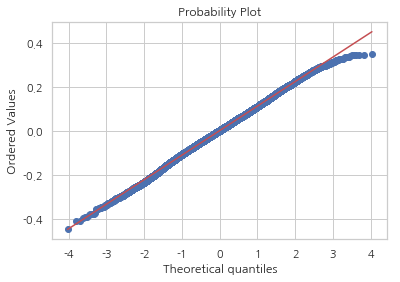

In [12]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [13]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 26.048
P-value     :  0.000


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

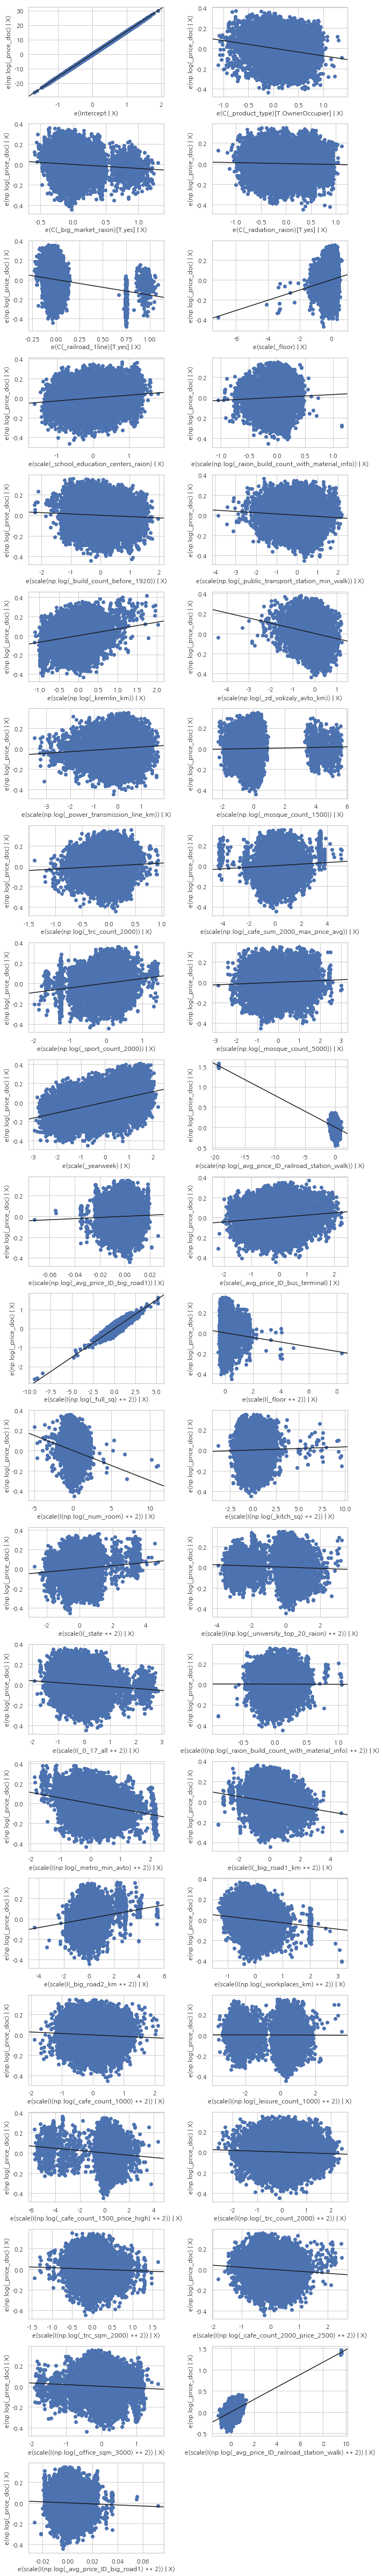

In [14]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [15]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.3953425780043296

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  3.,  1.,  4.,  2.,  1.,
         3.,  3.,  2.,  6.,  4.,  4.,  5.,  7.,  5.,  8., 17.,  9., 11.,
         8., 11.,  8., 18., 14., 20., 11., 16., 22., 24., 25., 26., 21.,
        34., 26., 33., 21., 37., 30., 28., 29., 27., 36., 20., 23., 31.,
        26., 21., 28., 19., 25., 16., 23., 24., 12., 13., 12., 19., 11.,
        10., 10.,  7.,  4.,  4.,  4.,  3.,  3.,  1.]),
 array([-0.70276811, -0.68705734, -0.67134658, -0.65563582, -0.63992505,
        -0.62421429, -0.60850353, -0.59279276, -0.577082  , -0.56137123,
        -0.54566047, -0.52994971, -0.51423894, -0.49852818, -0.48281741,
        -0.46710665, -0.45139589, -0.43568512, -0.41997436, -0.4042636 ,
        -0.38855283, -0.37284207, -0.3571313 , -0.34142054, -0.32570978,
        -0.30999901, -0.29428825, -0.27857749, -0.26286672, -0.247155

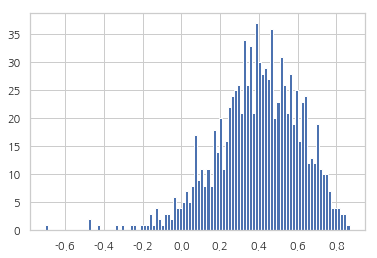

In [16]:
plt.hist(r2s, bins=100)

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('../submissions/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

## Score

RMSLE : 0.38405

In [18]:
for col in df_train_macro_with_outliers.columns:
    df_train_macro_with_outliers.rename(columns={col:col[1:]}, inplace=True)
for col in df_train_macro.columns:
    df_train_macro.rename(columns={col:col[1:]}, inplace=True)
df_train_macro_with_outliers.to_csv('../input/train_macro_with_outliers.csv', header=True, index=True)
df_train_macro.to_csv('../input/train_macro_without_outliers.csv', header=True, index=True)